<img src="../../thumbnail.png" width=500 alt="Kerchunk Logo"></img>

# Multi-file virtual datasets with VirtualiZarr

## Overview

This notebook is intends to build off of the [Basics of virtual Zarr stores](./01_kerchunk_basics.ipynb).

In this tutorial we will:
- Create a list of input paths for a collection of NetCDF files stored on the cloud.
- Create virtual datasets for each input datasets
- Combine the virtual datasets using combine_nested
- Read the combined dataset using [`Xarray`](https://docs.xarray.dev/en/stable/) and [`fsspec`](https://filesystem-spec.readthedocs.io/en/latest/).


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Basics of virtual Zarr stores](./01_kerchunk_basics.ipynb) | Required | Basic features |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Recommended | IO |

- **Time to learn**: 60 minutes
---

## Flags
In the section below, set the `subset` flag to be `True` (default) or `False` depending if you want this notebook to process the full file list. If set to `True`, then a subset of the file list will be processed (Recommended)

In [1]:
subset_flag = True

## Imports
In our imports block we are using similar imports to the [Basics of virtual Zarr stores tutorial](./01_kerchunk_basics.ipynb):
- `fsspec` for reading and writing to remote file systems
- `virtualizarr` will be used to generate the virtual Zarr store
- `Xarray` for examining the output dataset



In [2]:
import fsspec
import xarray as xr
from virtualizarr import open_virtual_dataset

### Create a File Pattern from a list of  input NetCDF files

Below we will create a list of input files we want to virtualize. In the [Basics of virtual Zarr stores tutorial](./01_kerchunk_basics.ipynb), we looked at a single file of climate downscaled data over Southern Alaska. In this example, we will build off of that work and use `Kerchunk` and `VirtualiZarr` to combine multiple NetCDF files of this dataset into a virtual dataset that can be read as if it were a `Zarr` store - without copying any data.

We use the `fsspec` `s3` filesystem's *glob* method to create a list of files matching a file pattern. We supply the base url of `s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/`, which is pointing to an `AWS` public bucket, for daily rcp85 ccsm downscaled data for the year 2060. After this base url, we tacked on *`*`*, which acts as a wildcard for all the files in the directory. We should expect 365 daily `NetCDF` files.

Finally, we are appending the string `s3://` to the list of return files. This will ensure the list of files we get back are `s3` urls and can be read by `VirtualiZarr` and `Kerchunk`.

In [3]:
# Initiate fsspec filesystems for reading and writing
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

# Retrieve list of available days in archive for the year 2060.
files_paths = fs_read.glob("s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/*")

# Here we prepend the prefix 's3://', which points to AWS.
files_paths = sorted(["s3://" + f for f in files_paths])

#### As a quick check, it looks like we have a list 365 file paths, which should be a year of downscaled climte data. 

In [4]:
print(f"{len(files_paths)} file paths were retrieved.")

365 file paths were retrieved.


In [5]:
# If the subset_flag == True (default), the list of input files will
# be subset to speed up the processing
if subset_flag:
    files_paths = files_paths[0:4]

### Optional: If you want to examine one NetCDF files before creating the `Kerchunk` index, try uncommenting this code snippet below.

In [6]:
## Note: Optional piece of code to view one of the NetCDFs

# import s3fs

# fs = fsspec.filesystem("s3",anon=True)
# ds = xr.open_dataset(fs.open(file_pattern[0]))

## Create virtual datasets for every file in the `File_Pattern` list

Now that we have a list of NetCDF files, we can use `VirtualiZarr` to create virtual datasets for each one of these.

### Define kwargs for `fsspec`
In the cell below, we are creating a dictionary of `kwargs` to pass to `fsspec` and the `s3` filesystem. Details on this can be found in the [Basics of virtual Zarr stores tutorial](./01_kerchunk_basics.ipynb) in the **Define storage_options arguments** section

In [7]:
storage_options = dict(anon=True, default_fill_cache=False, default_cache_type="first")

In the cell below, we are reusing some of the functionality from the previous tutorial. 
First we are defining a function named: `generate_json_reference`. 
This function:
- Uses an `fsspec` `s3` filesystem to read in a `NetCDF` from a given url.
- Generates a `Kerchunk` index using the `SingleHdf5ToZarr` `Kerchunk` method.
- Creates a simplified filename using some string slicing.
- Uses the local filesystem created with `fsspec` to write the `Kerchunk` index to a `.json` reference file.

Below the `generate_json_reference` function we created, we have a simple `for` loop that iterates through our list of `NetCDF` file urls and passes them to our `generate_json_reference` function, which appends the name of each `.json` reference file to a list named **output_files**.


In [8]:
virtual_datasets = [
    open_virtual_dataset(
        filepath, indexes={}, reader_options={"storage_options": storage_options}
    )
    for filepath in files_paths
]

## Combine virtual datasets

After we have generated a virtual dataset for each `NetCDF` file, we can combine these into a single virtual dataset using Xarray's `combine_nested` function.


In [9]:
combined_vds = xr.combine_nested(
    virtual_datasets, concat_dim=["Time"], coords="minimal", compat="override"
)
combined_vds

<xarray.Dataset> Size: 123MB
Dimensions:        (Time: 4, south_north: 250, west_east: 320,
                    interp_levels: 9, soil_layers_stag: 4)
Coordinates:
    interp_levels  (interp_levels) float32 36B ManifestArray<shape=(9,), dtyp...
    Time           (Time) int32 16B ManifestArray<shape=(4,), dtype=int32, ch...
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/39)
    SWDNB          (Time, south_north, west_east) float32 1MB ManifestArray<s...
    TMIN           (Time, south_north, west_east) float32 1MB ManifestArray<s...
    GHT            (Time, interp_levels, south_north, west_east) float32 12MB ManifestArray<shape=(4, 9, 250, 320), dtype=float32, chunks=(1, 9, 250, 320)...
    XLAT           (Time, south_north, west_east) float32 1MB ManifestArray<s...
    ALBEDO         (Time, south_north, west_east) float32 1MB ManifestArray<s...
    QVAPOR         (Time, interp_levels, south_north, west_east) float32 12MB ManifestArray<shape=(4, 9, 250, 320), dtype=float32, chunks=(1, 9, 250, 320)...
    ...             ...
    lon            (Time, south_north, west_east) float32 1MB ManifestArray<s...
    U10            (Time, south_north, west_east) float32 1MB ManifestArray<s...
    SWDNBC         (Time, south_north, west_east) float32 1MB ManifestArray<s...
    XLONG          (Time, south_north, west_east) float32 1MB ManifestArray<s...
    SNOW           (Time, south_north, west_east) float32 1MB ManifestArray<s...
    SNOWC          (Time, south_north, west_east) float32 1MB ManifestArray<s...

## Write combined virtual dataset to a Kerchunk JSON for future use
If we want to keep the combined reference information in memory as well as write the file to `.json`, we can run the code snippet below.

In [10]:
# Write kerchunk .json record
output_fname = "combined_kerchunk.json"
combined_vds.virtualize.to_kerchunk(output_fname, format="json")

## Using the output

Now that we have built a virtual dataset using `VirtualiZarr` and `Kerchunk`, we can read all of those original `NetCDF` files as if they were a single `Zarr` dataset. 


**Since we saved the combined virtual dataset, this work doesn't have to be repeated for anyone else to use this dataset. All they need is to pass the reference file storing the virtual dataset to `Xarray` and it is as if they had a `Zarr` dataset!

### Open combined virtual dataset with Kerchunk


In [11]:
# We once again need to provide information for fsspec to access the remote file
storage_options = dict(
    remote_protocol="s3", remote_options=dict(anon=True), skip_instance_cache=True
)
# We will use the "kerchunk" engine in `xr.open_dataset` and pass the `storage_options` to the `kerchunk` engine through `backend_kwargs`
ds = xr.open_dataset(
    output_fname,
    engine="kerchunk",
    backend_kwargs={"storage_options": storage_options},
)
ds

<xarray.Dataset> Size: 123MB
Dimensions:        (Time: 4, south_north: 250, west_east: 320,
                    interp_levels: 9, soil_layers_stag: 4)
Coordinates:
  * Time           (Time) float64 32B nan -2.147e+09 -2.147e+09 -2.147e+09
  * interp_levels  (interp_levels) float32 36B 100.0 200.0 300.0 ... 925.0 1e+03
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/39)
    ACSNOW         (Time, south_north, west_east) float32 1MB ...
    ALBEDO         (Time, south_north, west_east) float32 1MB ...
    CLDFRA         (Time, interp_levels, south_north, west_east) float32 12MB ...
    GHT            (Time, interp_levels, south_north, west_east) float32 12MB ...
    HFX            (Time, south_north, west_east) float32 1MB ...
    LH             (Time, south_north, west_east) float32 1MB ...
    ...             ...
    V              (Time, interp_levels, south_north, west_east) float32 12MB ...
    V10            (Time, south_north, west_east) float32 1MB ...
    XLAT           (Time, south_north, west_east) float32 1MB ...
    XLONG          (Time, south_north, west_east) float32 1MB ...
    lat            (Time, south_north, west_east) float32 1MB ...
    lon            (Time, south_north, west_east) float32 1MB ...

## Plot a slice of the dataset

Here we are using `Xarray` to select a single time slice of the dataset and plot a map of snow cover over South East Alaska.

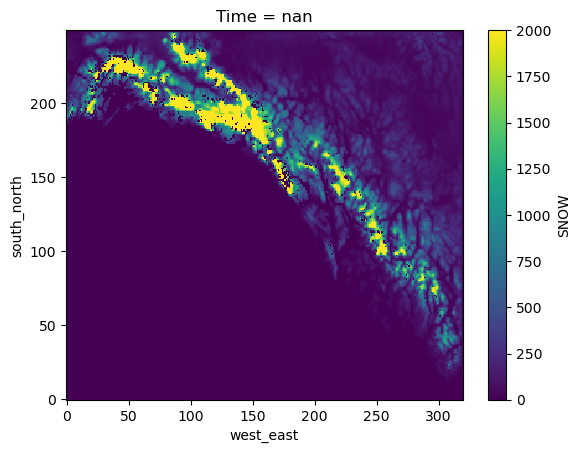

In [12]:
ds.isel(Time=0).SNOW.plot()